In [30]:
import pickle
from pathlib import Path
import sys
import time
from TwitterAPI import TwitterAPI
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter, defaultdict, deque
import copy
import math

In [31]:
def get_twitter():
    """ Construct an instance of TwitterAPI using the tokens you entered above.
    Returns:
      An instance of TwitterAPI.
      
    """
    consumer_key = 'tb9zMiyUJ9UeX6blluI4Wlws8'
    consumer_secret = 'XlGNdXHj6Rd2LJ2t9LodnCLydvO2kZ4KLoq95VnQRXfuKXDgZn'
    access_token = '3231404389-56xTceJ255ar5Sj2sQtWuDj8z0grnNedlqOt5AC'
    access_token_secret = 'qwPAoWezVnfgeQCCaJy03rOQUJG2Z9ZACzVPIjcqu7IKD'
    return TwitterAPI(consumer_key, consumer_secret, access_token, access_token_secret)

In [32]:
def open_file(tweets,fname):
    fname=fname+'.pkl'
    p = Path(fname)
    if p.is_file():
        with open(fname, "rb") as file:
            try:
                tweets = pickle.load(file)
            except EOFError:
                return tweets
    return tweets

In [33]:
def robust_request(twitter, screen_name, max_tries=1):
     for i in range(max_tries):
        request = twitter.request('friends/ids',{'screen_name' : screen_name, 'count' :5000})
        if request.status_code == 200:
            return request
        else:
            print('Got error %s \nsleeping for 15 minutes.' % request.text)
            sys.stderr.flush()
            time.sleep(61 * 15)

In [34]:
def find_unique_user(tweets):
    user=[]
    user_id=[]
    for i in tweets:
        user.append(i['screen_name'])
        user_id.append(i['userid'])
    return list(set(user)),list(set(user_id))

In [35]:
def find_twitter_frnds(tweeter_names,frnds_id):
    for each in tweeter_names[:5]:
        print (each)
        frnds_id[each] = sorted([friend_id for friend_id in robust_request(twitter,each)])
    return frnds_id

In [36]:
def draw_graph(names):
    """
    Create the  graph from ids of the followers. 
    """
    teams = list(names.keys())
    g = nx.Graph()
    for i in range(len(teams)):
        for j in range(i+1,len(teams)):
            a =list(set(names[teams[i]] ) & set(names[teams[j]]))
            for node in a:
                g.add_edges_from([(teams[i],node)]) 
                g.add_edges_from([(teams[j],node)])
                #g.add_edges_from([(teams[i],teams[j])])

    return g

In [37]:
%matplotlib inline
def read_graph(g,names):
    
    labels = {}
    pos = nx.spring_layout(g)
    plt.figure(figsize=(100,100))
    nx.draw(g, pos, with_labels=False,node_size =2500)
    for node in g.nodes():
        for i in names:
            if i == node:
                labels[node] = i
   
    nx.draw_networkx_labels(g,pos,labels=labels,font_size=50,font_color='b')
    plt.savefig("before_clusture.png")
    return g

In [38]:
def girvan_newman(G,minsize, maxsize):
   
    """
    Args:
    G.........a networkx graph
    minsize...the smallest acceptable size for a community
    maxsize...the largest acceptable size for a community

    Returns:
    A list of all discovered communities. This list is a list 
    of lists of strings. E.g., [['A', 'B'], ['C', 'D']] is a result
    containing two communities ((A,B) and (C,D)).
    """
    if G.order() == 1:
        return [G.nodes()]
    
    def find_best_edge(G0):
        eb = nx.edge_betweenness_centrality(G0)
        # eb is dict of (edge, score) pairs, where higher is better
        # Return the edge with the highest score.
        return sorted(eb.items(), key=lambda x: x[1], reverse=True)

    # Each component is a separate community. We cluster each of these.
    
    components = [c for c in nx.connected_component_subgraphs(G)]
    edge_to_remove = find_best_edge(G)
    count = 0
    while len(components) == 1:
        G.remove_edge(*edge_to_remove[count][0])
        count = count +1
        components = [c for c in nx.connected_component_subgraphs(G)]

    
    result = []
    for c in components:
        if (c.order()>=minsize and c.order()<=maxsize):
            result.append(c.nodes())
        elif c.order()>maxsize:
            result.extend(girvan_newman(c,minsize,maxsize))
    return result

In [39]:
def draw_network(graph, users, f):
      
    ###TODO 
    name="Cluster"+str(f)+".png"
    pos=nx.spring_layout(graph)    
    plt.figure(figsize=(50,50))    
    nx.draw(graph,pos,with_labels=False,node_size =3000)
    labels = {}
   
    for node in graph.nodes():
        for i in users:
            if i == node:
                labels[node] = i
    
    nx.draw_networkx_labels(graph,pos,labels=labels,font_size=55,font_color='b')
    plt.savefig(name)
    pass

In [40]:
def write_file(tweets):
    fname='Cluster.pkl'
    print("Cluster Information stored in file",fname)
    pickle.dump(tweets, open(fname, 'wb'))

Mutual number of followers for the team #thunderup #WeTheNorth ----> 6
Mutual number of followers for the team #thunderup #DefendTheLand ----> 9
Mutual number of followers for the team #thunderup #DetroitBasketball ----> 12
Mutual number of followers for the team #thunderup #GrindCity ----> 9
Mutual number of followers for the team #thunderup #LakeShow ----> 5
Mutual number of followers for the team #thunderup #DubNation ----> 7
Mutual number of followers for the team #WeTheNorth #DefendTheLand ----> 6
Mutual number of followers for the team #WeTheNorth #DetroitBasketball ----> 11
Mutual number of followers for the team #WeTheNorth #GrindCity ----> 16
Mutual number of followers for the team #WeTheNorth #LakeShow ----> 3
Mutual number of followers for the team #WeTheNorth #DubNation ----> 14
Mutual number of followers for the team #DefendTheLand #DetroitBasketball ----> 24
Mutual number of followers for the team #DefendTheLand #GrindCity ----> 8
Mutual number of followers for the team #

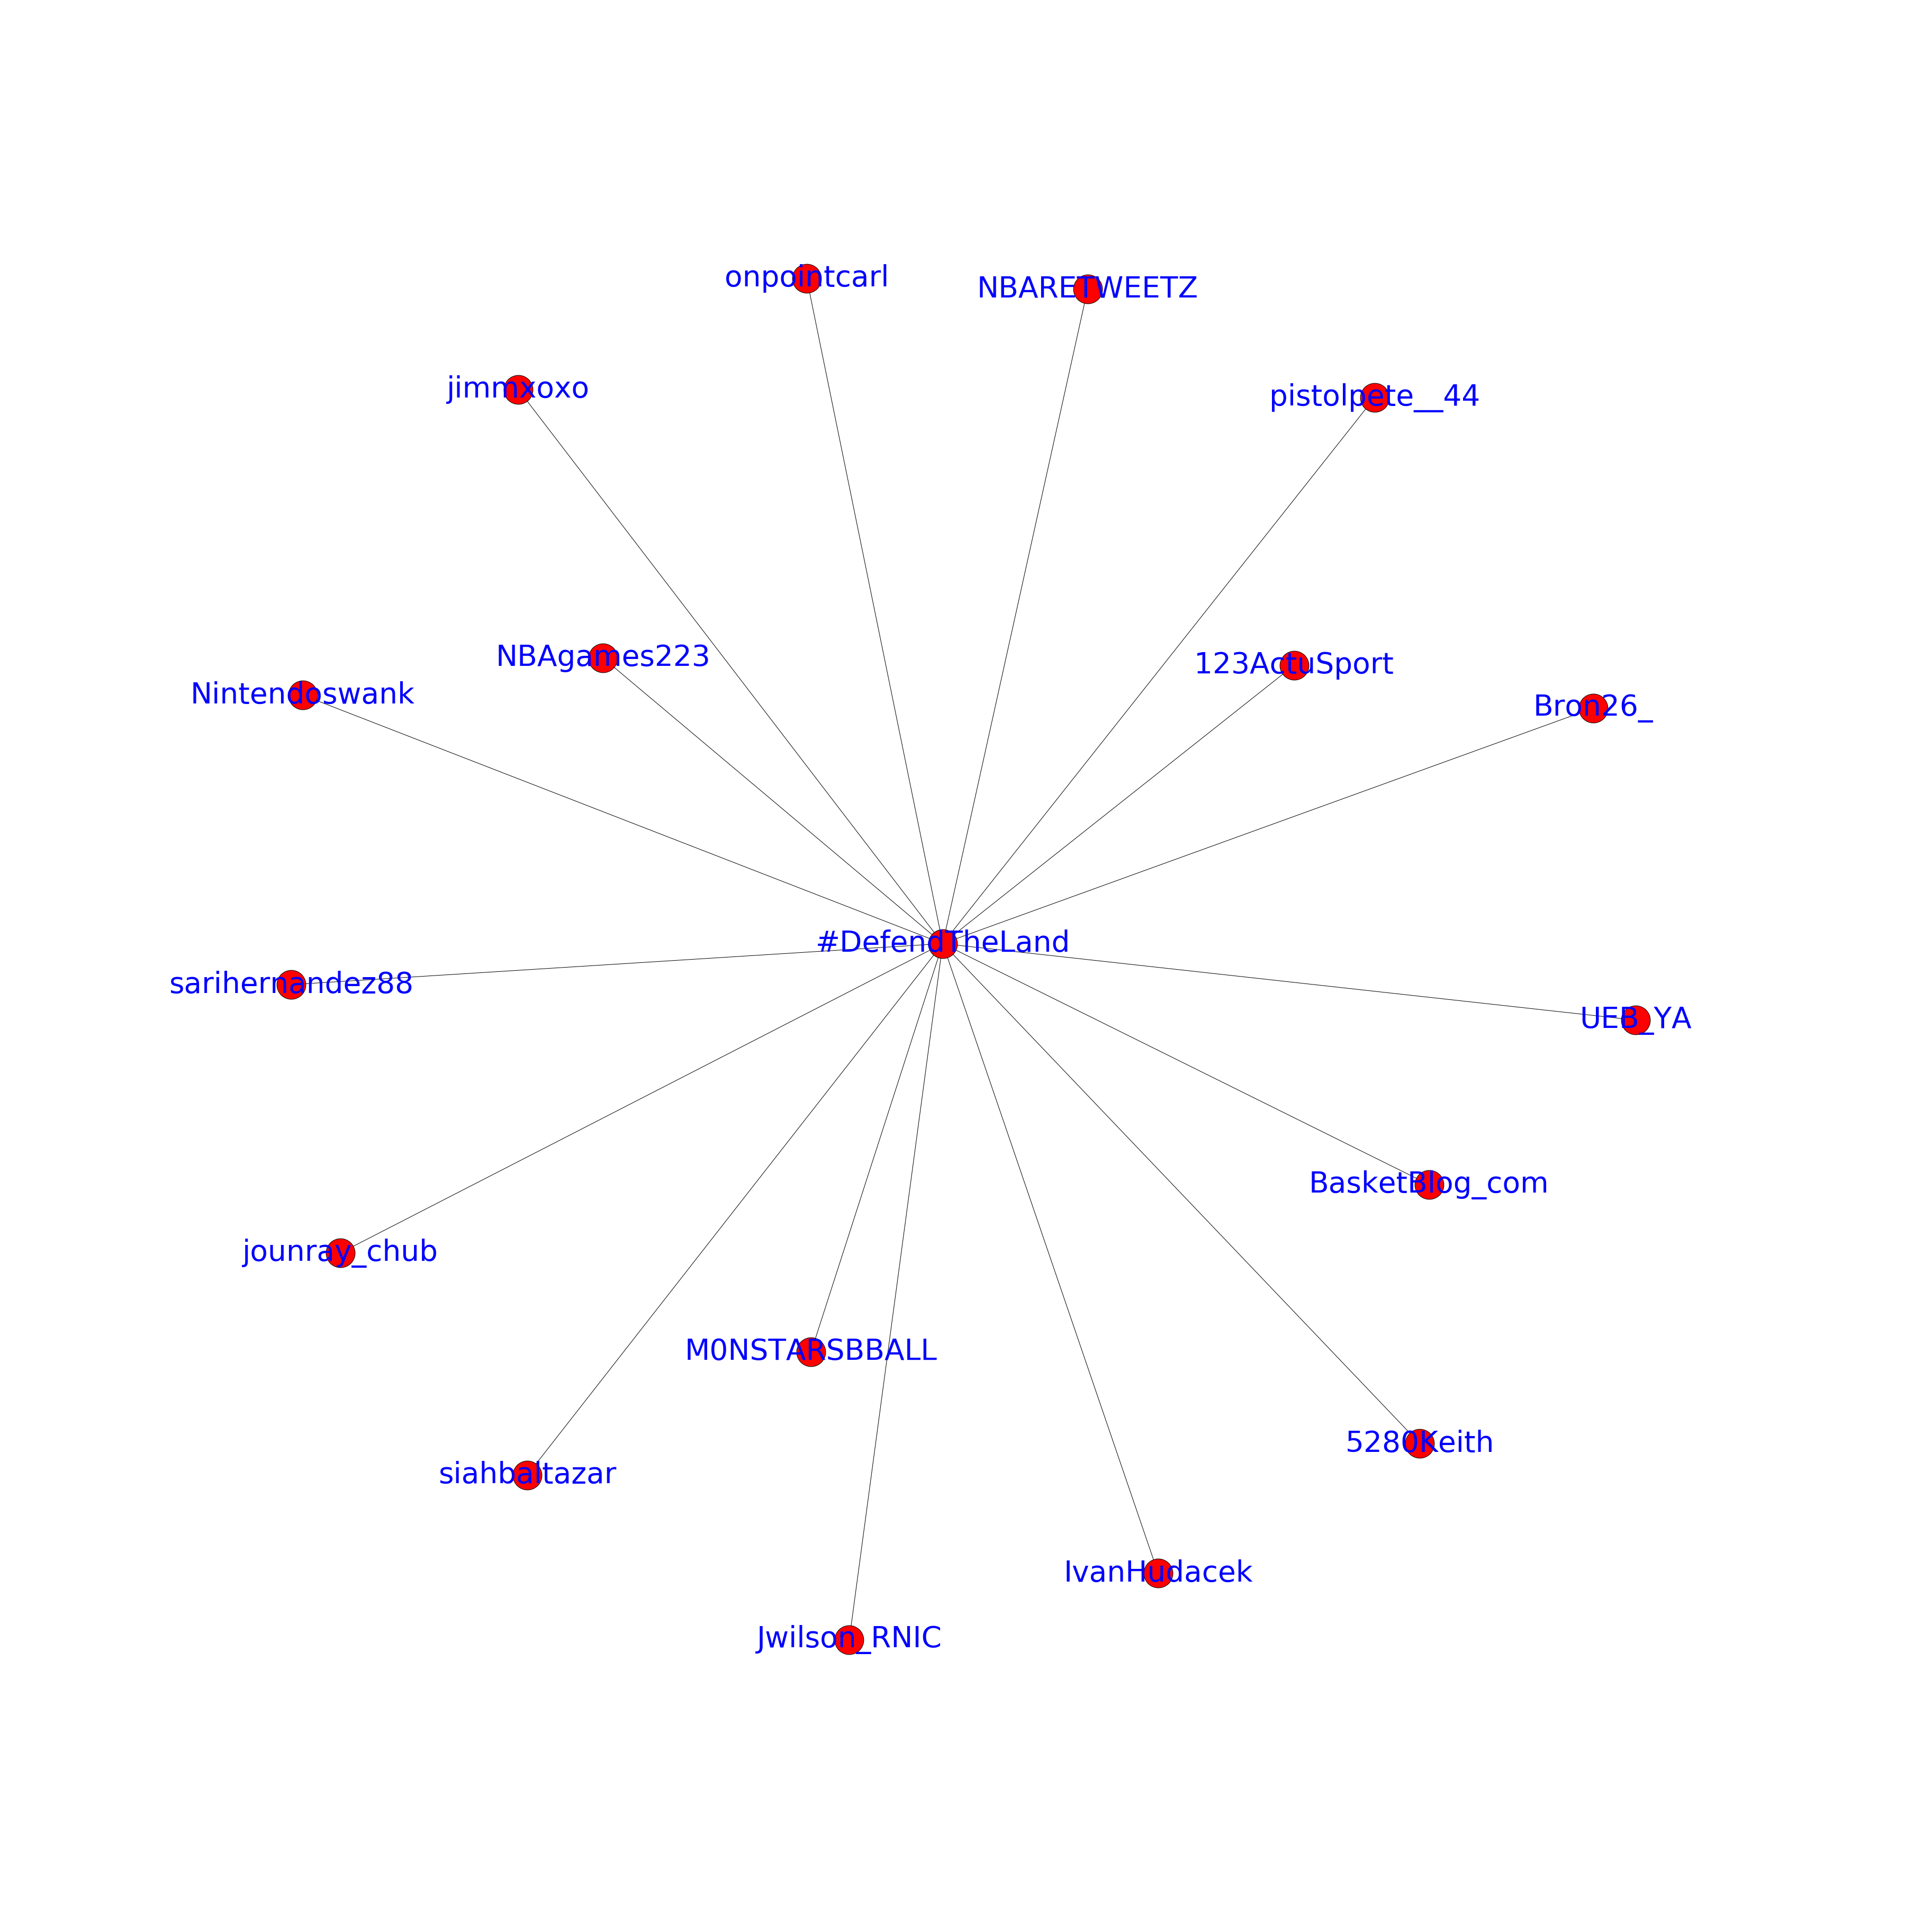

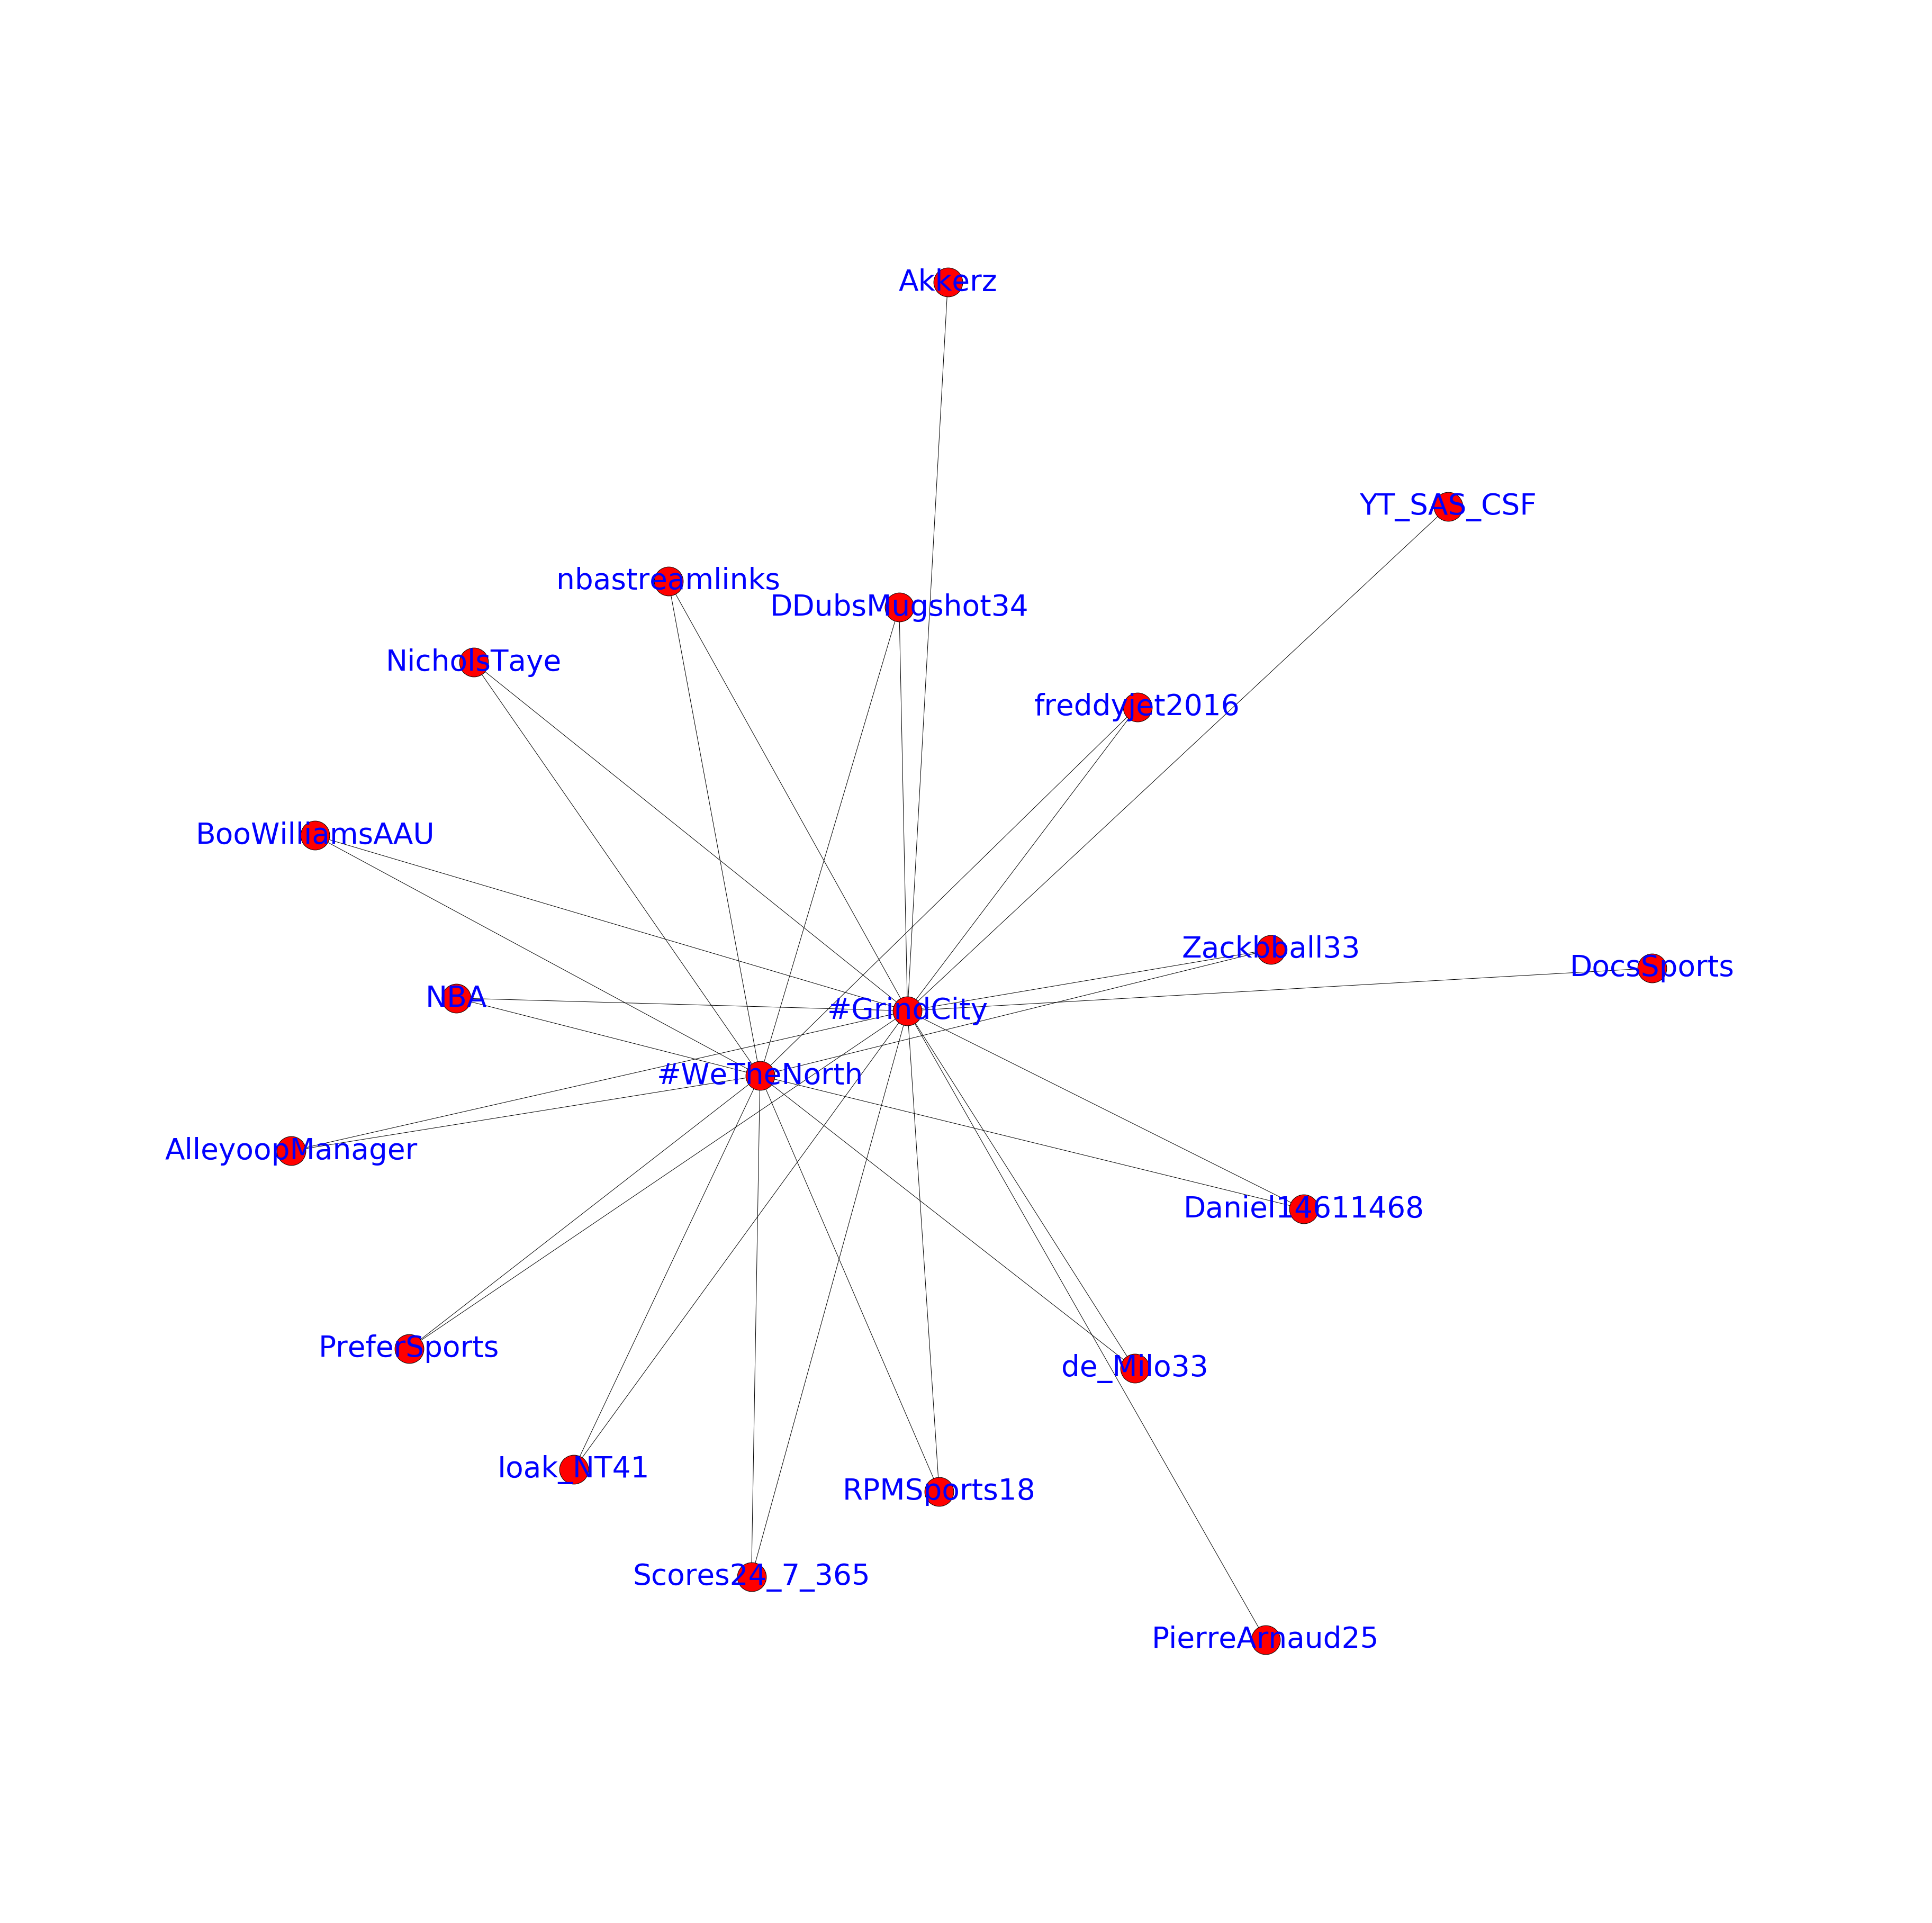

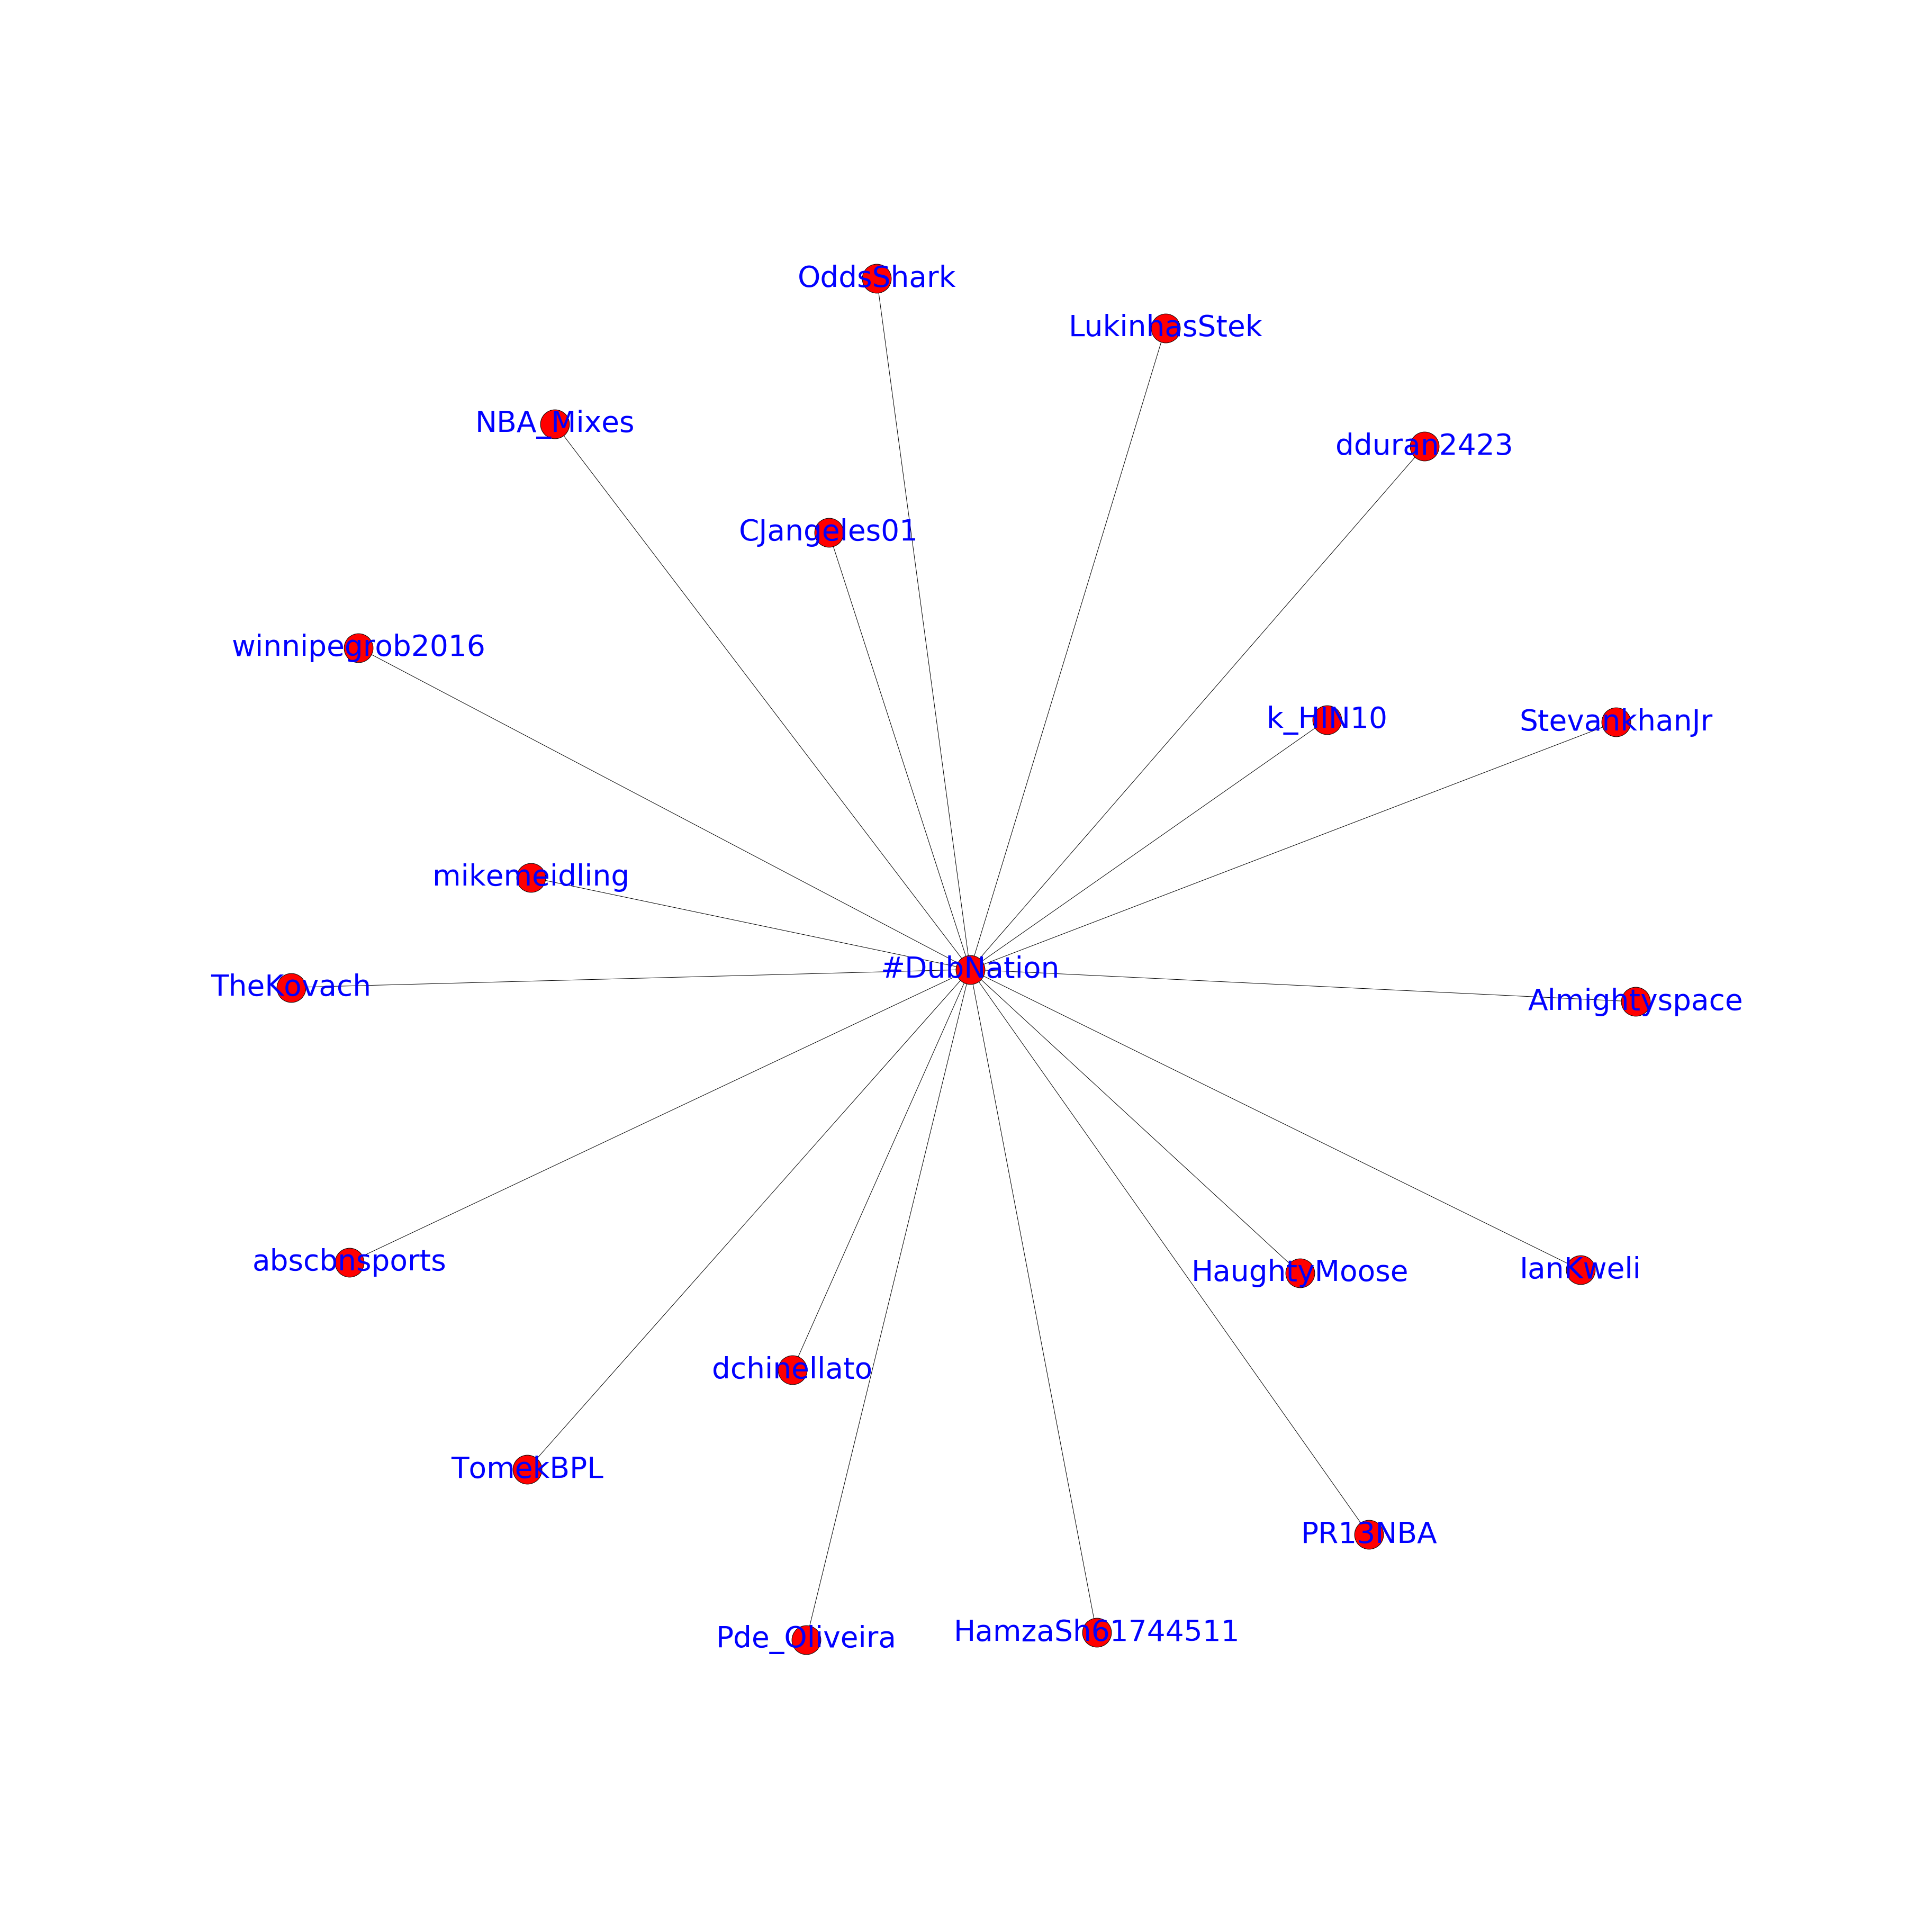

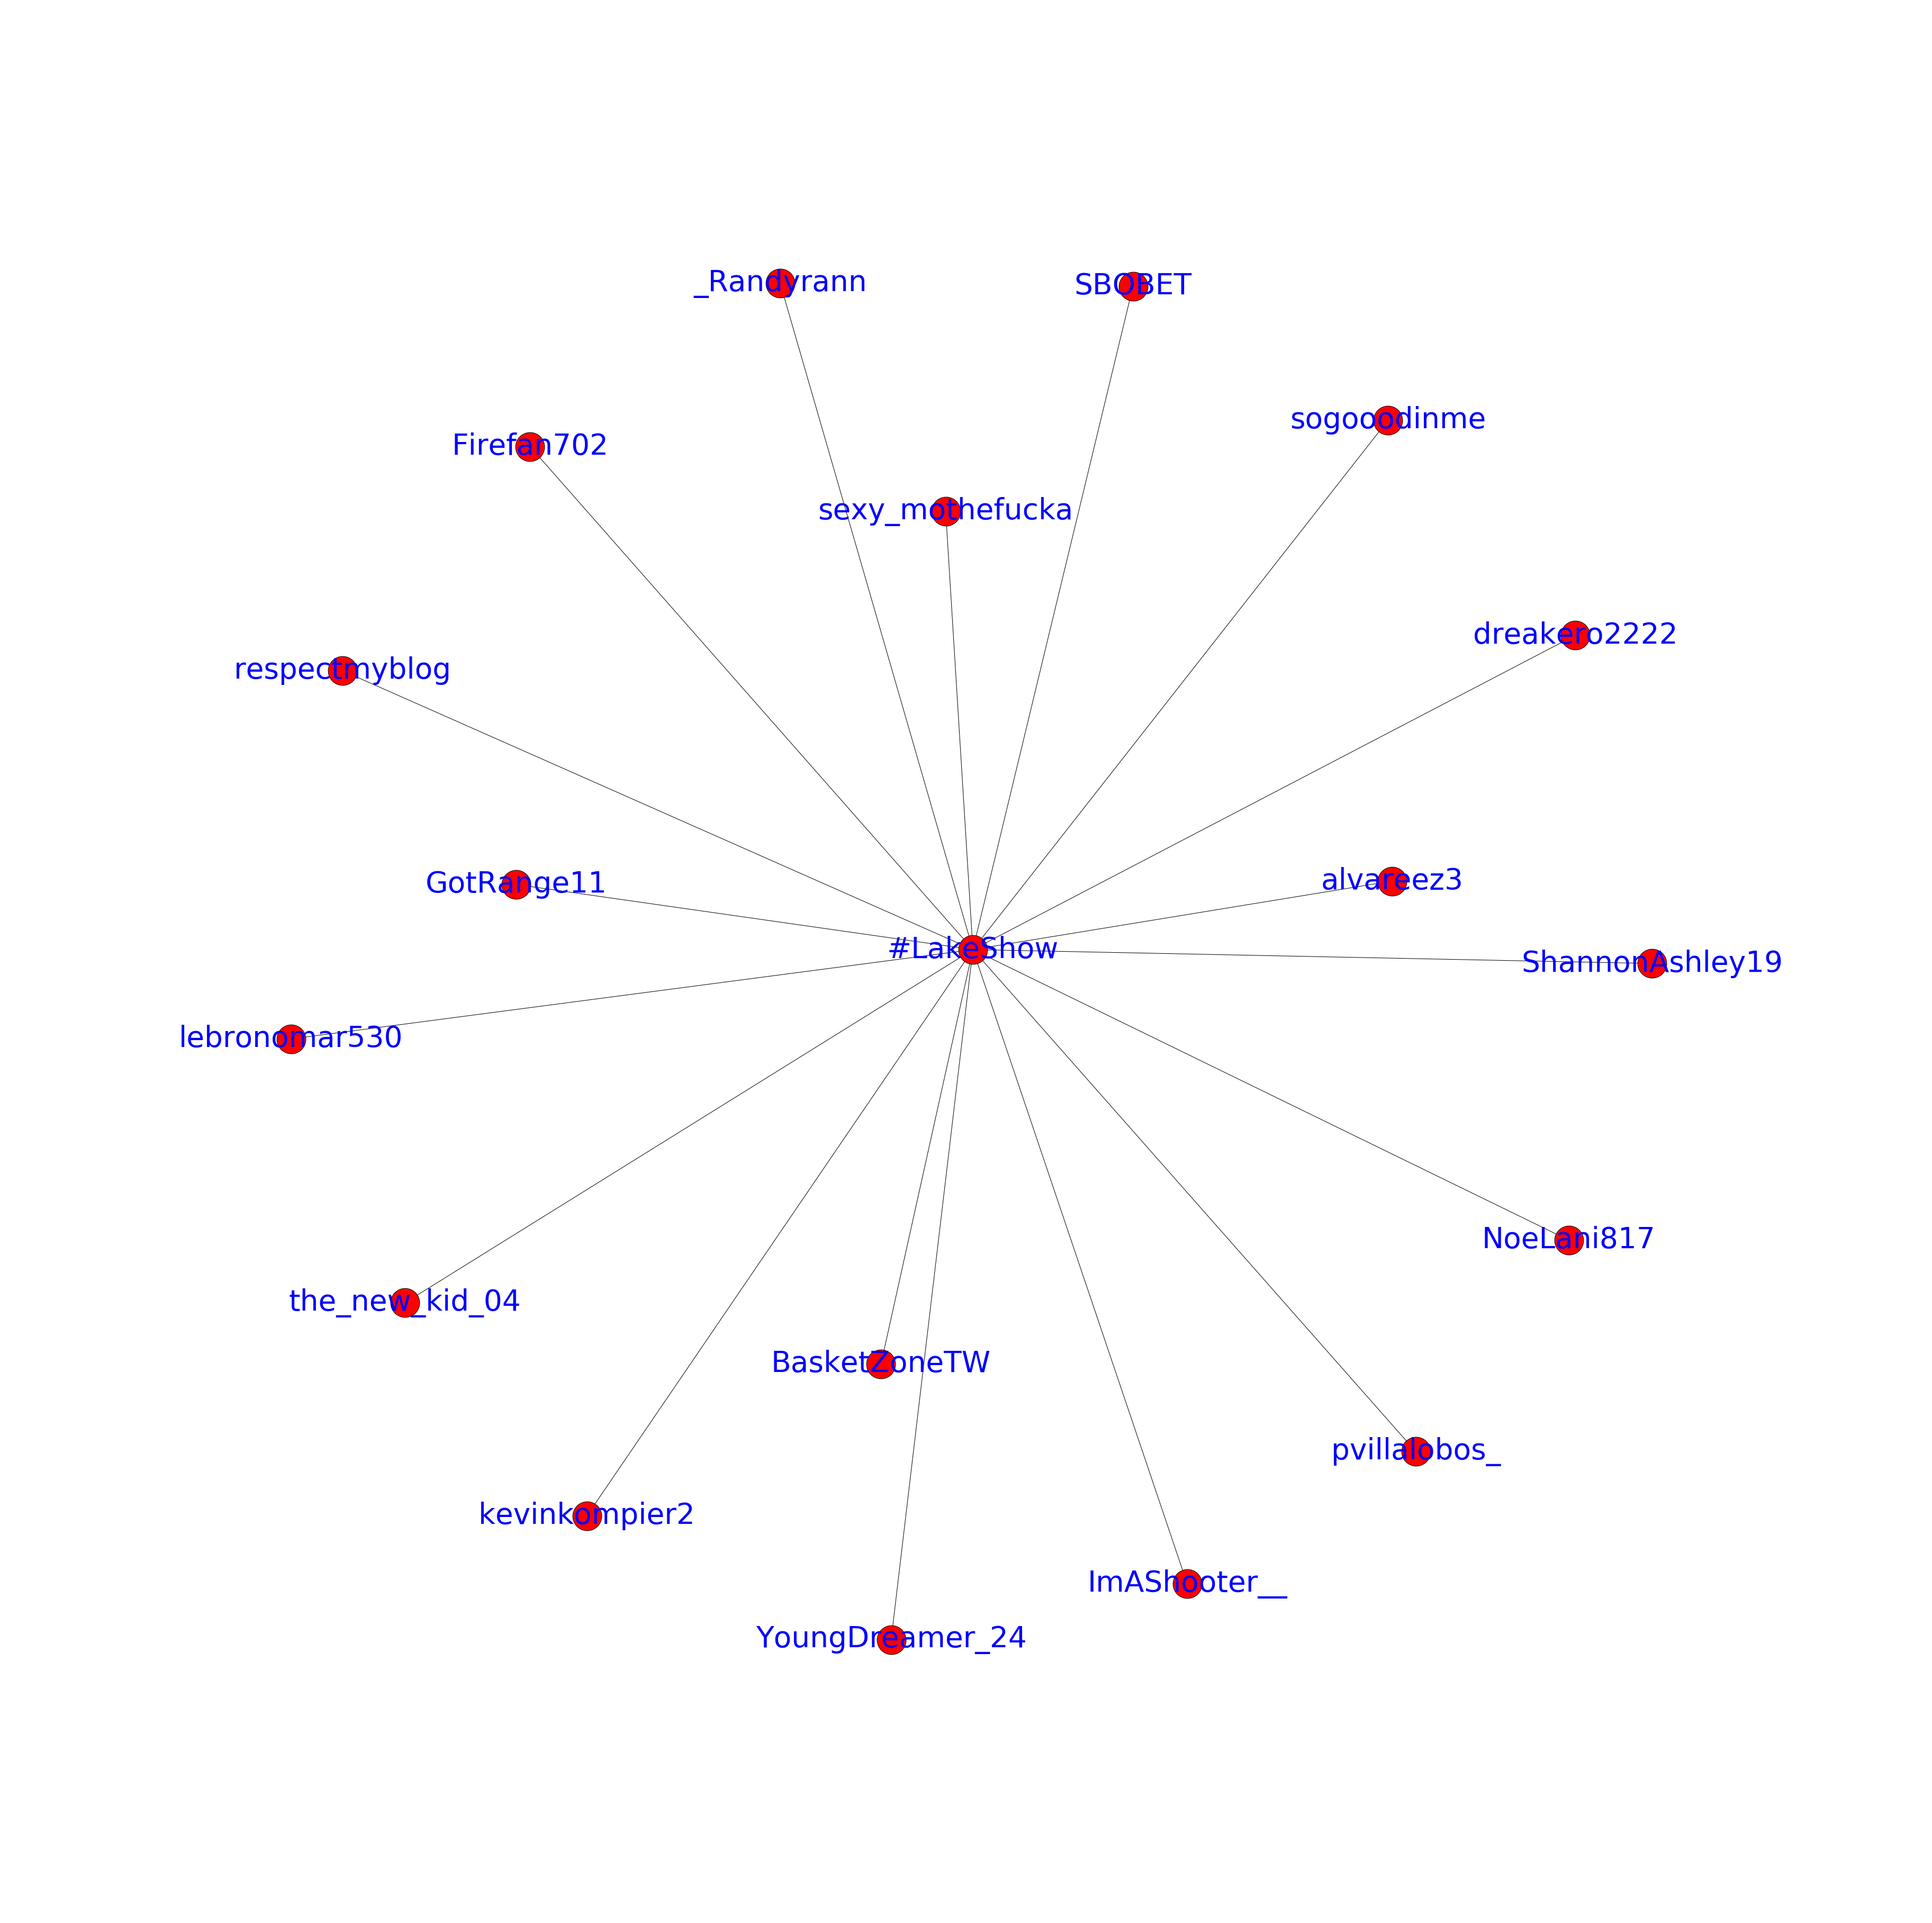

In [41]:
def main():
    twitter = get_twitter()
    tweets=[]
    names={}   
    hashtags=['#DubNation','#WeTheNorth','#GrindCity','#DetroitBasketball','#thunderup','#LakeShow','#DefendTheLand']
    count=0
    for tags in hashtags:
        tweets= open_file(tweets,tags)
        tweeter_names,tweeter_id=find_unique_user(tweets)
        count+=len(tweeter_names)
        names[tags]=tweeter_names
    teams = list(names.keys())
    for i in range(len(teams)):
        for j in range(i+1,len(teams)):
                a =list(set(names[teams[i]] ) & set(names[teams[j]]))
                print ("Mutual number of followers for the team",teams[i],teams[j],"---->",len(a))           
 
    graph=draw_graph(names) 
    g=read_graph(graph,names)
    print('graph has %d nodes and %d edges' %(graph.order(), graph.number_of_edges()))
    result=girvan_newman(g,10, 20)
    name=1
    TEMP={}
    for i in range(1,len(result)):
        print ('cluster %d  Number of nodes/followers %d' %(i ,len(result[i])))
        draw_network(graph.subgraph(result[i]),result[i],i)
        TEMP[i]=result[i]
        TEMP['usercount']=count
    write_file(TEMP)
        
        
if __name__ == '__main__':
    main()